**3rd Step) Domain Shift** <br><br>

From now on, we will employ BiSeNet as our segmentation to ease the resource requirements of the next experiments.
Consider as upper bound the results obtained in Table 2, i.e. the segmentation networks trained on the labeled target images (Cityscapes). <br>
Evaluating the domain shift problem in Semantic Segmentation 
In semantic segmentation collecting manually annotated images is expensive. A popular solution consists in adopting synthetic datasets (i.e. artificial images generated in a simulation environment).<br>
Specifically, in this step we employ the synthetic images from GTA5 [5] (source domain) to train our real-time segmentation network, which is then evaluated on the real images from Cityscapes [5] (target domain).<br><br>
Dataset: GTA5 [5]<br>
Training Set:  GTA5 <br>
Validation Set: Cityscapes [5] validation split<br> 
Training epochs: 50<br>
Training resolution (GTA5): 1280x720<br>
Test resolution (Cityscapes): 1024x512<br>
Backbone: ResNet18 (pre-trained on ImageNet) [2] <br>
Semantic Classes: 19 <br>
Metrics: mIoU <br>

In [2] We finetune the model weights of the Imagenet-pretrained
VGG-16 or ResNet-101 networks to adapt them to the
semantic segmentation task in a straightforward fashion,
following the procedure of [14]. We replace the 1000-way
Imagenet classifier in the last layer with a classifier having as
many targets as the number of semantic classes of our task
(including the background, if applicable). Our loss function
is the sum of cross-entropy terms for each spatial position
in the CNN output map (subsampled by 8 compared to
the original image). All positions and labels are equally
weighted in the overall loss function (except for unlabeled
pixels which are ignored). Our targets are the ground truth
labels (subsampled by 8). We optimize the objective function
with respect to the weights at all network layers by the
standard SGD procedure of [2]. We decouple the DCNN
and CRF training stages, assuming the DCNN unary terms
are fixed when setting the CRF parameters.

**Training details**: We use mini-batch stochastic gradient descent (SGD) [16] with
batch size 16, momentum 0.9 and weight decay 1e
−4
in training. Similar to
[5, 6, 21], we apply the “poly” learning rate strategy in which the initial rate
is multiplied by (1 −
iter
max iter )
power each iteration with power 0.9. The initial
learning rate is 2.5e
−2
.

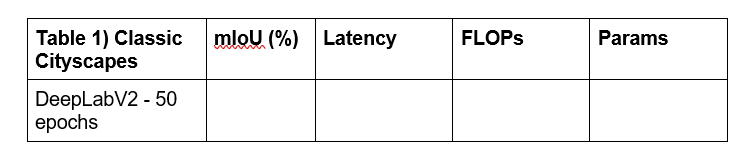

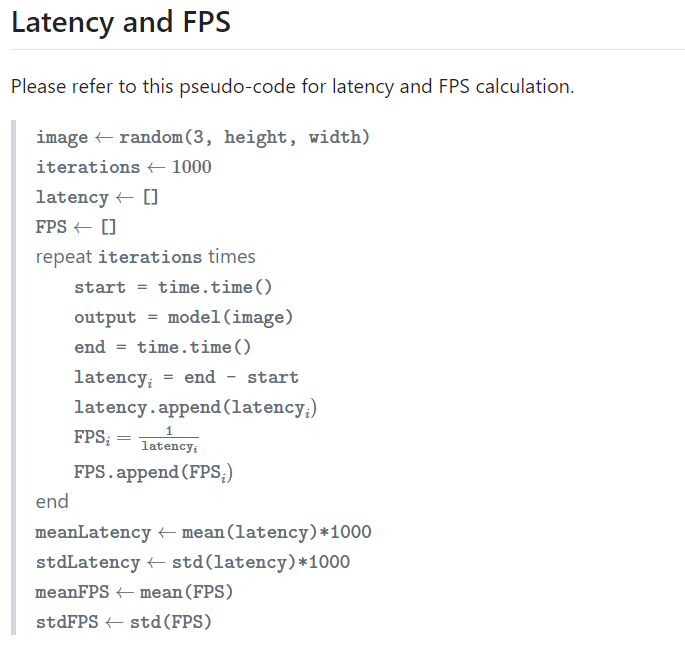

In [ ]:
# !pip install -U fvcore

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import requests
from torchvision.datasets import ImageFolder
from torchvision import models
from PIL import Image
from shutil import copyfile
import os

# os.chdir('/content/drive/My Drive')
from datasets.cityscapes import CityscapesDataset
from datasets.gta5 import GTA5

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((1280,720)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_lbl_transform = transforms.Compose([
    transforms.Resize((1280,720), interpolation=Image.Resampling.NEAREST),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((1024,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_lbl_transform = transforms.Compose([
    transforms.Resize((1024,512), interpolation=Image.Resampling.NEAREST),
    transforms.ToTensor(),
])

In [7]:
train_dataset = GTA5('datasets\\GTA5', transform=[train_transform,train_lbl_transform]) # /content/drive/MyDrive/datasets/GTA5 
val_dataset = CityscapesDataset('datasets\\Cityscapes\\Cityspaces', transform=[val_transform,val_lbl_transform]) # /content/drive/MyDrive/datasets/Cityscapes/Cityscapes/Cityspaces 

train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True) #16
val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=True) #16

In [8]:
for images, labels in train_dataloader:
    # Access the first image and label
    image, label = images[0], labels[0]
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)
    print("Label:", label)

    break

Image shape: torch.Size([3, 1280, 720])
Label shape: torch.Size([1, 1280, 720])
Label: tensor([[[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]]])


In [9]:
for images, labels in val_dataloader:
    # Access the first image and label
    image, label = images[0], labels[0]
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)
    print("Label:", label)

    break

Image shape: torch.Size([3, 1024, 512])
Label shape: torch.Size([1, 1024, 512])
Label: tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


In [10]:
# Load pre-trained model

from models.bisenet.build_bisenet import BiSeNet
bisenet = BiSeNet(num_classes = 19, context_path='resnet18').to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:03<00:00, 51.7MB/s]


In [11]:
bisenet

BiSeNet(
  (saptial_path): Spatial_path(
    (convblock1): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (convblock2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (convblock3): ConvBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (context_path): resnet18(
    (features): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [12]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [13]:
# Get the length of class_names (one output unit for each class)
output_shape = 19 # 0 to 18

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.SGD(bisenet.parameters(), lr=2.5e-2, momentum=0.9, weight_decay=1e-4)

In [17]:
def train(model, optimizer, dataloader, loss_fn):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = inputs, targets
        targets = torch.argmax(targets, dim=1)

        outputs,_,_ = model(inputs)

        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)

    train_loss = running_loss / len(dataloader)


def test(model, dataloader, loss_fn):

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = inputs, targets
            targets = torch.argmax(targets, dim=1)

            outputs = model(inputs)
            # outputs, _, _ = model(inputs)

            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)

    test_loss = test_loss / len(dataloader)

    return test_loss

In [18]:
from torch.optim.lr_scheduler import PolynomialLR

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
epochs = 1 #50

## Inserting learning rate decay
scheduler = PolynomialLR(optimizer, total_iters=50, power=0.9)

for _ in range(epochs):
    train(bisenet, optimizer, train_dataloader, loss_fn)
    test_loss = test(bisenet, val_dataloader, loss_fn)
    scheduler.step()
    print(f"Test loss: {test_loss}")


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
# latency and FPS

import time
from torch.utils.data import RandomSampler

iterations = 1000
random_sampler = RandomSampler(dataset, replacement=False, num_samples=iterations)
random_dataloader = DataLoader(dataset, batch_size=1, sampler=random_sampler)

latency = []
fps = []
with torch.no_grad():
    for inputs, _ in random_dataloader:
        start = time.time()
        prediction = model(inputs)
        end = time.time()
        latency_i = end - start
        latency.append(latency_i)
        fps_i = 1/latency_i
        fps.append(fps_i)

meanLatency = np.mean(latency)*1000
stdLatency = np.std(latency)*1000
meanfps = np.mean(fps)
stdfps = np.std(fps)

print("Mean Latency:", meanLatency)
print("Std Latency:", stdLatency)
print("Mean FPS:", meanfps)
print("Std FPS:", stdfps)

In [ ]:
# FLOPs and parameters

from fvcore.nn import FlopCountAnalysis, flop_count_table

height = 512
width = 1024
image = torch.zeros((3, height, width))

flops = FlopCountAnalysis(model, image)
print(flop_count_table(flops))

In [ ]:
def getting_data_results_analysis(model, dataloader):

    model.eval()
    samples = []
    all_targets = []
    preds = []
    probs = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            targets = torch.argmax(targets, dim=1)
            outputs, _, _ = model(inputs)
            _, predicted = outputs.max(1)
            probs.append(_)
            preds.append(predicted)
            all_targets.append(targets)
            samples.append(inputs)

    samples = torch.cat(samples, dim=0)
    preds = torch.cat(preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    probs = torch.cat(probs, dim=0)

    return samples, preds, all_targets, probs

samples, preds, target, probs = getting_data_results_analysis(bisenet, test_dataloader)

In [ ]:
# Evaluating mIoU

from torchmetrics.classification import MulticlassJaccardIndex

metric = MulticlassJaccardIndex(num_classes=19)
metric(preds, target)